### COGS 118B Final Project

In [685]:
# import all the relevant libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse.linalg import eigsh
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Start with the MNIST Dataset

In [686]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Then, split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Reshape the data
X_train = X_train.reshape(-1, 28*28)
X_val = X_val.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

#### Create a Classifier

In [687]:
# create a svm classifier
classifier = SVC(kernel = 'rbf', random_state=21)
classifier.fit(X_train, y_train)

SVC(random_state=21)

### Baseline performance of the classifier

In [688]:
y_train_pred = classifier.predict(X_train)

# Calculate training accuracy
training_accuracy = accuracy_score(y_train, y_train_pred)

In [689]:
print(training_accuracy)

0.9892666666666666


### Baseline validation accuracy of the classifier

In [690]:
Y_val_pred = classifier.predict(X_val)

# Calculate validation accuracy
validation_accuracy = accuracy_score(y_val, Y_val_pred)

In [691]:
print(validation_accuracy)

0.9765333333333334


### Baseline testting accuracy of the classifier

In [692]:
Y_test_pred = classifier.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, Y_test_pred)

In [693]:
print(test_accuracy)

0.9773


### Create the segmentation using spectral clustering

In [694]:
def similarity(xi, xj, sigma=1.0):
    '''
    calculates RBF similarity between two vectors of the same size
    
    parameters: 
        xi, xj are numpy arrays or other iterable defining two vectors
        sigma is the RBF normalization constant (default 1.0)
    returns: 
        the RBF similarity function defined in the cell above for xi, xj
    '''
    return np.exp(-np.sum((xi - xj) ** 2) / (2 * sigma**2))



def construct_similarity_matrix(X, sigma=1.0):
    '''
    calculates an affinity matrix using RBF similarity between rows of a matrix
    
    parameters:
        X is an NxD matrix
        sigma is the RBF normalization constant (default 1.0)
    returns:
        the NxN affinity matrix 
    '''
    X = X.reshape(-1, 1)
    sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * X @ X.T

    # Compute RBF kernel
    similarity_matrix = np.exp(-sq_dists / (2 * sigma**2))
    return similarity_matrix


#### Run the Clustering algorithm on the dataset and see if it changes the accuracy

In [695]:
N = X_train.shape[0]
sigma = 0.9
train_outputs = np.zeros((N,784))
count = 0

for image in X_train:
    A = construct_similarity_matrix(image / 255,sigma)
    D = np.diag(np.sum(A,axis=1))
    L = np.eye(784) - (np.diag(1.0 / np.sqrt(np.diag(D)))) @ A @ (np.diag(1.0 / np.sqrt(np.diag(D))))
    eigenvalues, eigenvectors = eigsh(L, k=2, which='SM')  # Sparse eigen decomposition
    eigenvectors = np.real(eigenvectors)
    divmat = np.sqrt(np.sum(eigenvectors**2, axis=1)).reshape(-1, 1)
    # Run kmeans on eigenvectors and plot spectral clustering
    kmeans = KMeans(n_clusters=2).fit(eigenvectors / divmat)
    kk = kmeans.labels_
    c1 = np.argwhere(kk == 0)
    c2 = np.argwhere(kk == 1)

    output = np.zeros(784)
    output[c2] = 1
    train_outputs[count] = output
    count += 1


In [696]:
train_output_predictions = classifier.predict(train_outputs)

# Calculate accuracy
train_output_accuracy = accuracy_score(y_train, train_output_predictions)
print(f'Training Accuracy post clustering: {train_output_accuracy}')

Training Accuracy post clustering: 0.8375555555555556


#### Now we can try it with the Validation Set

In [697]:
N = X_val.shape[0]
sigma = 0.9
val_outputs = np.zeros((N,784))
count = 0

for image in X_val:
    A = construct_similarity_matrix(image / 255,sigma)
    D = np.diag(np.sum(A,axis=1))
    L = np.eye(784) - (np.diag(1.0 / np.sqrt(np.diag(D)))) @ A @ (np.diag(1.0 / np.sqrt(np.diag(D))))
    eigenvalues, eigenvectors = eigsh(L, k=2, which='SM')  # Sparse eigen decomposition
    eigenvectors = np.real(eigenvectors)
    divmat = np.sqrt(np.sum(eigenvectors**2, axis=1)).reshape(-1, 1)
    # Run kmeans on eigenvectors and plot spectral clustering
    kmeans = KMeans(n_clusters=2).fit(eigenvectors / divmat)
    kk = kmeans.labels_
    c1 = np.argwhere(kk == 0)
    c2 = np.argwhere(kk == 1)

    output = np.zeros(784)
    output[c2] = 1
    val_outputs[count] = output
    count += 1


In [698]:
val_output_predictions = classifier.predict(val_outputs)

# Calculate accuracy
val_output_accuracy = accuracy_score(y_val, val_output_predictions)
print(f'Validation Accuracy post clustering: {val_output_accuracy}')

Validation Accuracy post clustering: 0.8316666666666667


#### Finally, we can try it with the Test Set

In [699]:
N = X_test.shape[0]
sigma = 0.9
test_outputs = np.zeros((N,784))
count = 0

for image in X_test:
    A = construct_similarity_matrix(image / 255,sigma)
    D = np.diag(np.sum(A,axis=1))
    L = np.eye(784) - (np.diag(1.0 / np.sqrt(np.diag(D)))) @ A @ (np.diag(1.0 / np.sqrt(np.diag(D))))
    eigenvalues, eigenvectors = eigsh(L, k=2, which='SM')  # Sparse eigen decomposition
    eigenvectors = np.real(eigenvectors)
    divmat = np.sqrt(np.sum(eigenvectors**2, axis=1)).reshape(-1, 1)
    # Run kmeans on eigenvectors and plot spectral clustering
    kmeans = KMeans(n_clusters=2).fit(eigenvectors / divmat)
    kk = kmeans.labels_
    c1 = np.argwhere(kk == 0)
    c2 = np.argwhere(kk == 1)

    output = np.zeros(784)
    output[c2] = 1
    test_outputs[count] = output
    count += 1


In [700]:
test_output_predictions = classifier.predict(test_outputs)

# Calculate accuracy
test_output_accuracy = accuracy_score(y_test, test_output_predictions)
print(f'Testing Accuracy post clustering: {test_output_accuracy}')

Testing Accuracy post clustering: 0.8274


#### Let's use the post-clustered images to train the new classifier

In [701]:
# create a svm classifier
cluster_classifier = SVC(kernel = 'rbf', random_state=21)
cluster_classifier.fit(train_outputs, y_train)

SVC(random_state=21)

#### Find the performance of the new classifier

In [702]:
# Evaluate training accuracy
new_train_predictions = cluster_classifier.predict(train_outputs)
new_train_accuracy = accuracy_score(y_train, new_train_predictions)
print(f'Training Accuracy: {new_train_accuracy}')

# Evaluate validation accuracy
new_val_predictions = cluster_classifier.predict(val_outputs)
new_val_accuracy = accuracy_score(y_val, new_val_predictions)
print(f'Validation Accuracy: {new_val_accuracy}')

# Evaluate testing accuracy
new_test_predictions = cluster_classifier.predict(test_outputs)
new_test_accuracy = accuracy_score(y_test, new_test_predictions)
print(f'Testing Accuracy: {new_test_accuracy}')

Training Accuracy: 0.9816888888888889
Validation Accuracy: 0.9654666666666667
Testing Accuracy: 0.9666


#### Let's try the original data for fun

In [703]:
# Evaluate training accuracy
new_train_predictions = cluster_classifier.predict(X_train)
new_train_accuracy = accuracy_score(y_train, new_train_predictions)
print(f'Training Accuracy: {new_train_accuracy}')

# Evaluate validation accuracy
new_val_predictions = cluster_classifier.predict(X_val)
new_val_accuracy = accuracy_score(y_val, new_val_predictions)
print(f'Validation Accuracy: {new_val_accuracy}')

# Evaluate testing accuracy
new_test_predictions = cluster_classifier.predict(X_test)
new_test_accuracy = accuracy_score(y_test, new_test_predictions)
print(f'Testing Accuracy: {new_test_accuracy}')

Training Accuracy: 0.9694888888888888
Validation Accuracy: 0.9595333333333333
Testing Accuracy: 0.9631


From this little thought experiment, we can notice a small but interesting finding. Running spectral clustering on the dataset prior to creating the classifier may not significantly increase or decrease the performance of the classifier. However, it did make it more robust. We used the same numbers but, with different pixel intensities (the post-classified one only had 0/1 whereas the orginial dataset had values that ranged the grayscale spectrum). This can be helpful to create a more robust classifier where the semantic features are more important than the pixel intensities. 

#### Let's now try the procedure with the handwritten text characters

In [704]:
from scipy.io import loadmat

# Load the dataset
data = loadmat('matlab/emnist-letters.mat')

In [705]:
# Access the train/test data
train_images = np.array(data['dataset']['train'][0][0][0][0][0])  # Extract train images
train_labels = np.array(data['dataset']['train'][0][0][0][0][1])  # Extract train labels

test_images = np.array(data['dataset']['test'][0][0][0][0][0])    # Extract test images
test_labels = np.array(data['dataset']['test'][0][0][0][0][1])    # Extract test labels

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

Train images shape: (124800, 784)
Train labels shape: (124800, 1)


#### Split the data into three different sets

In [706]:
# Then, split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

# Reshape the data
X_train = X_train.reshape(-1, 28*28)
X_val = X_val.reshape(-1, 28*28)
X_test = test_images.reshape(-1, 28*28)

#### We will reduce the size of the dataset to ensure that our resources are able to support the training

In [ ]:
X_train = X_train[:50000,:] / 255
y_train = y_train[:50000]

X_val = X_val[:10000,:] / 255
y_val = y_val[:10000]

X_test = X_test / 255
y_test = test_labels

#### Let's now train a new classifier on this

In [708]:
# create a svm classifier
letter_classifier = SVC(kernel = 'rbf', random_state=21)
letter_classifier.fit(X_train, y_train)

c:\Users\prita\anaconda3\envs\COS118B\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(random_state=21)

#### Again, baseline the model

In [709]:
# Evaluate training accuracy
letter_train_predictions = letter_classifier.predict(X_train)
letter_train_accuracy = accuracy_score(y_train, letter_train_predictions)
print(f'Training Accuracy: {letter_train_accuracy}')

# Evaluate validation accuracy
letter_val_predictions = letter_classifier.predict(X_val)
letter_val_accuracy = accuracy_score(y_val, letter_val_predictions)
print(f'Validation Accuracy: {letter_val_accuracy}')

# Evaluate testing accuracy
letter_test_predictions = letter_classifier.predict(X_test)
letter_test_accuracy = accuracy_score(y_test, letter_test_predictions)
print(f'Testing Accuracy: {letter_test_accuracy}')

Training Accuracy: 0.93426
Validation Accuracy: 0.8847
Testing Accuracy: 0.88875


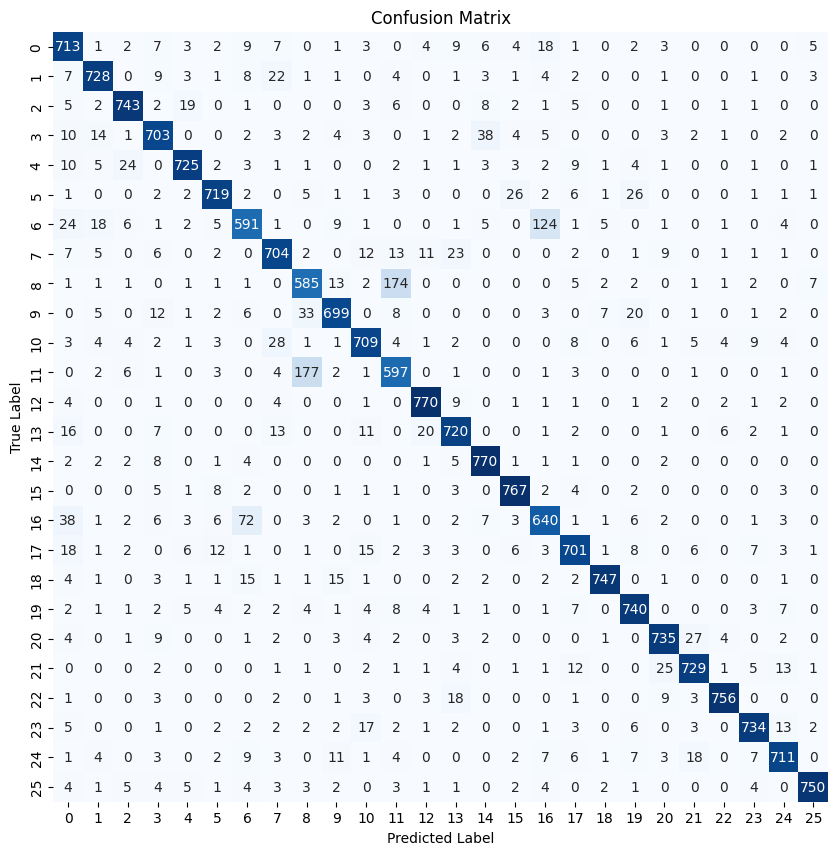

In [710]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, letter_test_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### We will now pre-process the training data using spectral clustering and then train the classifier

In [711]:
N = X_train.shape[0]
sigma = 0.9
letter_train_outputs = np.zeros((N,784))
count = 0

for image in X_train:
    A = construct_similarity_matrix(image / 255,sigma)
    D = np.diag(np.sum(A,axis=1))
    L = np.eye(784) - (np.diag(1.0 / np.sqrt(np.diag(D)))) @ A @ (np.diag(1.0 / np.sqrt(np.diag(D))))
    eigenvalues, eigenvectors = eigsh(L, k=2, which='SM')  # Sparse eigen decomposition
    eigenvectors = np.real(eigenvectors)
    divmat = np.sqrt(np.sum(eigenvectors**2, axis=1)).reshape(-1, 1)
    # Run kmeans on eigenvectors and plot spectral clustering
    kmeans = KMeans(n_clusters=2).fit(eigenvectors / divmat)
    kk = kmeans.labels_
    c1 = np.argwhere(kk == 0)
    c2 = np.argwhere(kk == 1)

    output = np.zeros(784)
    output[c2] = 1
    letter_train_outputs[count] = output
    count += 1

In [712]:
# evaluate training accuracy
letter_train_output_predictions = letter_classifier.predict(letter_train_outputs)
letter_train_output_accuracy = accuracy_score(y_train, letter_train_output_predictions)
print(f'Training Accuracy post clustering: {letter_train_output_accuracy}')

Training Accuracy post clustering: 0.73586


In [713]:
# create a svm classifier
letter_cluster_classifier = SVC(kernel = 'rbf', random_state=21)
letter_cluster_classifier.fit(letter_train_outputs, y_train)

c:\Users\prita\anaconda3\envs\COS118B\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(random_state=21)

In [714]:
# evaluate training accuracy
new_letter_train_predictions = letter_cluster_classifier.predict(letter_train_outputs)
new_letter_train_accuracy = accuracy_score(y_train, new_letter_train_predictions)
print(f'Training Accuracy: {new_letter_train_accuracy}')

Training Accuracy: 0.9203


#### Let's repeat the same for the validation and the test data

In [715]:
# run clustering on validation set
N = X_val.shape[0]
sigma = 0.9
letter_val_outputs = np.zeros((N,784))
count = 0

for image in X_val:
    A = construct_similarity_matrix(image,sigma)
    D = np.diag(np.sum(A,axis=1))
    L = np.eye(784) - (np.diag(1.0 / np.sqrt(np.diag(D)))) @ A @ (np.diag(1.0 / np.sqrt(np.diag(D))))
    eigenvalues, eigenvectors = eigsh(L, k=2, which='SM')  # Sparse eigen decomposition
    eigenvectors = np.real(eigenvectors)
    divmat = np.sqrt(np.sum(eigenvectors**2, axis=1)).reshape(-1, 1)
    # Run kmeans on eigenvectors and plot spectral clustering
    kmeans = KMeans(n_clusters=2).fit(eigenvectors / divmat)
    kk = kmeans.labels_
    c1 = np.argwhere(kk == 0)
    c2 = np.argwhere(kk == 1)

    output = np.zeros(784)
    output[c2] = 1
    letter_val_outputs[count] = output

In [716]:
# evaluate validation accuracy
new_letter_val_predictions = letter_cluster_classifier.predict(X_val)
new_letter_val_accuracy = accuracy_score(y_val, new_letter_val_predictions)
print(f'Validation Accuracy: {new_letter_val_accuracy}')

Validation Accuracy: 0.8227


In [717]:
N = X_test.shape[0]
sigma = 0.9
letter_test_outputs = np.zeros((N,784))
count = 0

for image in X_test:
    A = construct_similarity_matrix(image,sigma)
    D = np.diag(np.sum(A,axis=1))
    L = np.eye(784) - (np.diag(1.0 / np.sqrt(np.diag(D)))) @ A @ (np.diag(1.0 / np.sqrt(np.diag(D))))
    eigenvalues, eigenvectors = eigsh(L, k=2, which='SM')  # Sparse eigen decomposition
    eigenvectors = np.real(eigenvectors)
    divmat = np.sqrt(np.sum(eigenvectors**2, axis=1)).reshape(-1, 1)
    # Run kmeans on eigenvectors and plot spectral clustering
    kmeans = KMeans(n_clusters=2).fit(eigenvectors / divmat)
    kk = kmeans.labels_
    c1 = np.argwhere(kk == 0)
    c2 = np.argwhere(kk == 1)

    output = np.zeros(784)
    output[c2] = 1
    letter_test_outputs[count] = output
    count += 1

In [718]:
# evaluate testing accuracy
new_letter_test_predictions = letter_cluster_classifier.predict(letter_test_outputs)
new_letter_test_accuracy = accuracy_score(y_test, new_letter_test_predictions)
print(f'Testing Accuracy: {new_letter_test_accuracy}')

Testing Accuracy: 0.8603365384615385


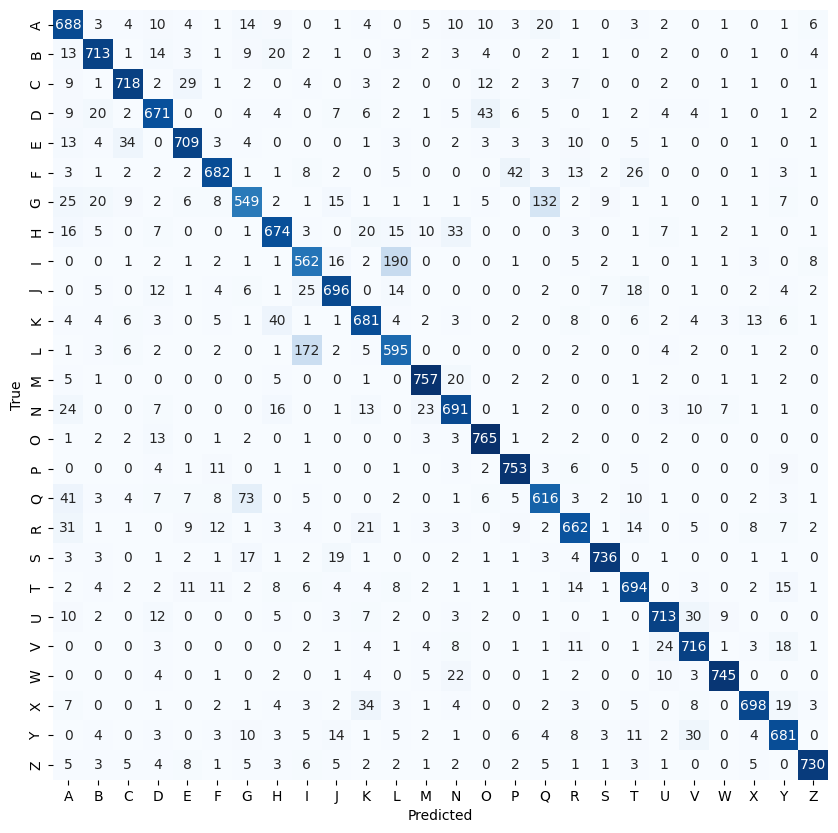

In [741]:
# get the confusion matrix
confusion_matrix(y_test, new_letter_test_predictions)

# Decode the labels to A-Z
decoded_labels = [decode_label(label) for label in range(1, 27)]

# Plot the confusion matrix with A-Z labels
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, new_letter_test_predictions), annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

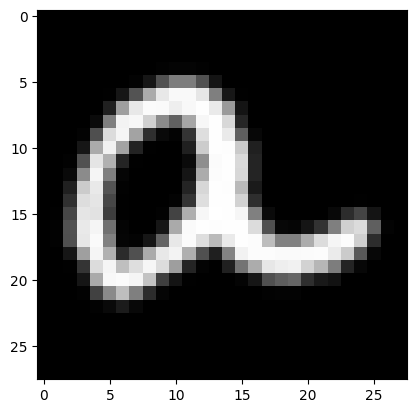

In [720]:
plt.imshow(X_test[7].reshape(28,28).T, cmap='gray')

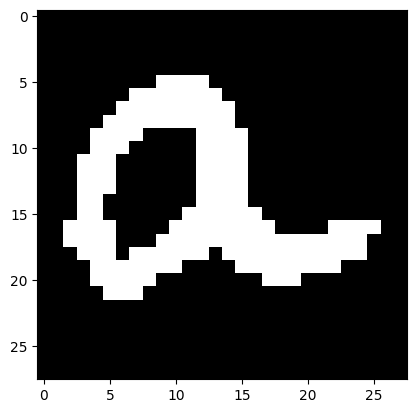

In [721]:
plt.imshow(letter_test_outputs[7].reshape(28,28).T, cmap='gray')

We can again see that the the spctral clustering makes a robust enhancement to the classifier workflow. We now have a benchmark on how our OCR will perform with the added spectral clustering.

#### We will now introduce a new metric to make the spectral clustering adept for multiple letters. We will do this by also quanitfying how close pixels are to each other in the image.

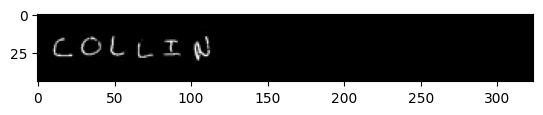

In [722]:
from PIL import Image

# Open an image file
image_path = 'train_v2/train/TRAIN_00116.jpg'
image = Image.open(image_path)
image_array = np.array(image.convert('L'))

plt.imshow(image_array, cmap='binary')

Until now, the spectral clustering was just using the pixel intensities. Hence, it worked fine with images where we have one number and two distinct intensities. In order to further improve the system, we need to account for the proxmitity pixels have to other pixels of the same intensity. In order to do this, we can project the image onto a 3 dimension subspace and add the x and y coordinate of the pixel in order to make the spectral clustering also factor that into its similarity calculations.

#### Notes: Up until now, we have been normalizing the intensity of the pixel values to assist the numerical solvers. This will cause a problem in this case since we want the pixel intensities to have a higher weightage. So, we need to ensure the pixel intensities are >> than the x, y coordinates.

In [748]:
# create a function to map the image into the 3-D subspace

def project_image(img):
    # Create X and Y coordinate matrices
    x_coords, y_coords = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]))

    image_data = img.flatten()

    # Flatten X and Y matrices to match the flattened image
    x_flat = x_coords.flatten()
    y_flat = y_coords.flatten()

    # Stack the image data with x and y coordinates
    image_with_coords = np.vstack([image_data/15, x_flat, y_flat])
    return image_with_coords

def similarity(xi, xj, sigma=1.0):
    '''
    calculates RBF similarity between two vectors of the same size
    
    parameters: 
        xi, xj are numpy arrays or other iterable defining two vectors
        sigma is the RBF normalization constant (default 1.0)
    returns: 
        the RBF similarity function defined in the cell above for xi, xj
    '''
    return np.exp(-np.sum((xi - xj) ** 2) / (2 * sigma**2))



def construct_similarity_matrix(X, sigma=1.0):
    '''
    calculates an affinity matrix using RBF similarity between rows of a matrix
    
    parameters:
        X is an NxD matrix
        sigma is the RBF normalization constant (default 1.0)
    returns:
        the NxN affinity matrix 
    '''
    
    sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * X @ X.T

    # Compute RBF kernel
    similarity_matrix = np.exp(-sq_dists / (2 * sigma**2))
    return similarity_matrix

In [724]:
def decode_label(input):
    mapping = {
        '1': 'A',
        '2': 'B',
        '3': 'C',
        '4': 'D',
        '5': 'E',
        '6': 'F',
        '7': 'G',
        '8': 'H',
        '9': 'I',
        '10': 'J',
        '11': 'K',
        '12': 'L',
        '13': 'M',
        '14': 'N',
        '15': 'O',
        '16': 'P',
        '17': 'Q',
        '18': 'R',
        '19': 'S',
        '20': 'T',
        '21': 'U',
        '22': 'V',
        '23': 'W',
        '24': 'X',
        '25': 'Y',
        '26': 'Z'
    }

    return mapping[str(input)]

#### Let's try our new method with the an image from the training set

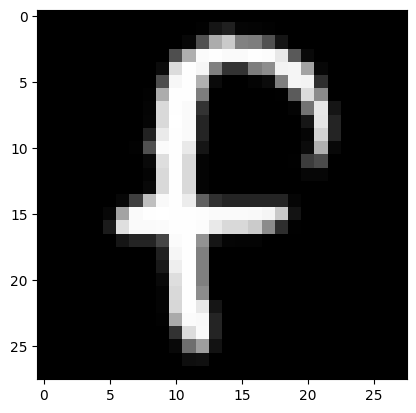

In [725]:
plt.imshow(X_test[4000].reshape(28,28).T, cmap='gray')

In [749]:
image_with_coords = project_image(X_test[4000].reshape(28,28)*255)

sigma = 2
A = construct_similarity_matrix(image_with_coords.T,sigma)
D = np.diag(np.sum(A,axis=1))
L = np.eye(784) - (np.diag(1.0 / np.sqrt(np.diag(D)))) @ A @ (np.diag(1.0 / np.sqrt(np.diag(D))))
eigenvalues, eigenvectors = np.linalg.eig(L)
eigenvectors = np.real(eigenvectors[:, eigenvalues.argsort()[:2]])
divmat = np.sqrt(np.sum(eigenvectors**2, axis=1)).reshape(-1, 1)
# Run kmeans on eigenvectors and plot spectral clustering
kmeans = KMeans(n_clusters=2).fit(eigenvectors / divmat)
kk = kmeans.labels_
c1 = np.argwhere(kk == 0)
c2 = np.argwhere(kk == 1)

image = np.zeros(784)
image[c2] = 1

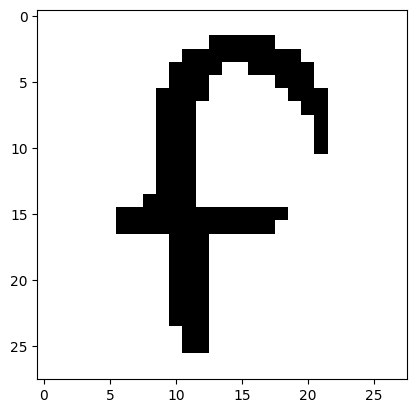

In [750]:
plt.imshow(image.reshape(28,28).T, cmap='binary')

We note that this image produces the same result as the prior method

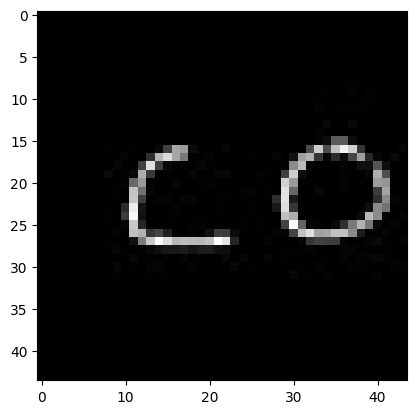

In [728]:
plt.imshow(image_array[:44,:44], cmap='binary')

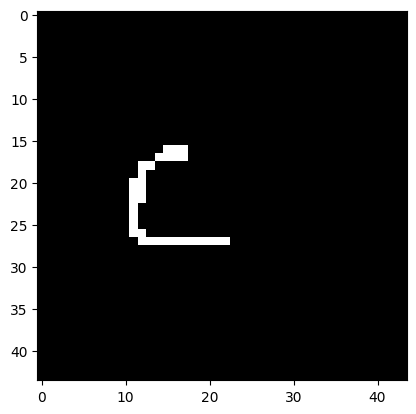

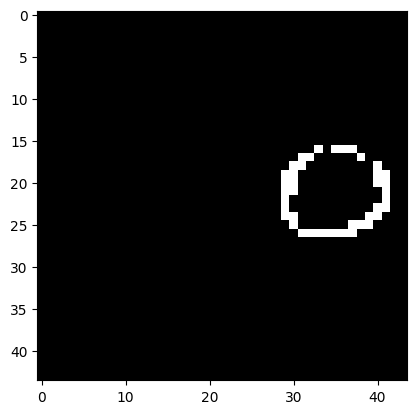

In [752]:
two_img_with_coords = project_image(image_array[:44,:44])

sigma = 1.4
A = construct_similarity_matrix(two_img_with_coords.T,sigma)
D = np.diag(np.sum(A,axis=1))
L = np.eye(1936) - (np.diag(1.0 / np.sqrt(np.diag(D)))) @ A @ (np.diag(1.0 / np.sqrt(np.diag(D))))
eigenvalues, eigenvectors = np.linalg.eig(L)
eigenvectors = np.real(eigenvectors[:, eigenvalues.argsort()[:3]])
divmat = np.sqrt(np.sum(eigenvectors**2, axis=1)).reshape(-1, 1)
# Run kmeans on eigenvectors and plot spectral clustering
kmeans = KMeans(n_clusters=3).fit(eigenvectors / divmat)
kk = kmeans.labels_
c1 = np.argwhere(kk == 0)
c2 = np.argwhere(kk == 1)
c3 = np.argwhere(kk == 2)

image1 = np.ones(1936)
image1[c3] = 0

plt.imshow(image1.reshape(44,44), cmap='binary')
plt.show()

image2 = np.ones(1936)
image2[c2] = 0

plt.imshow(image2.reshape(44,44), cmap='binary')
plt.show()


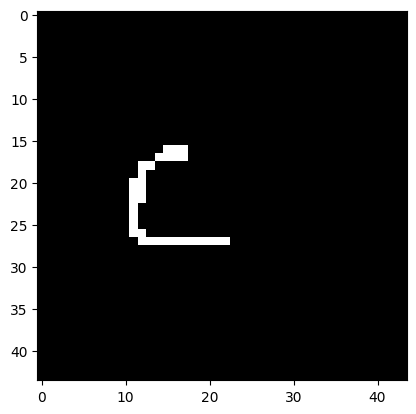

In [730]:
image1 = Image.fromarray((image1.reshape(44,44)).astype(np.uint8))

plt.imshow(image1, cmap='binary')

In [731]:
image1 = image1.resize((28,28))

In [732]:
image1 = np.array(image1).T
decode_label(letter_cluster_classifier.predict(image1.flatten().reshape(1,-1))[0])

'L'

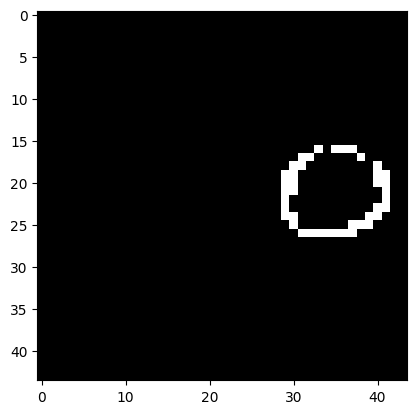

In [733]:
image2 = Image.fromarray((image2.reshape(44,44)).astype(np.uint8))

plt.imshow(image2, cmap='binary')

In [734]:
image2 = image2.resize((28,28))

image2 = np.array(image2).T
decode_label(letter_cluster_classifier.predict(image2.flatten().reshape(1,-1))[0])

'J'

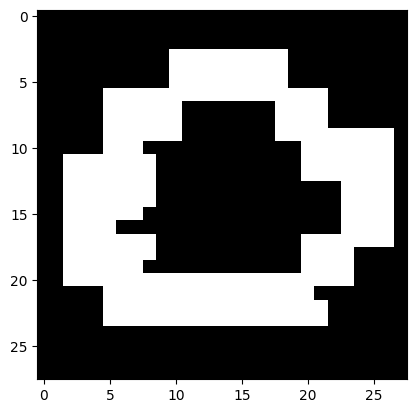

In [756]:
img = Image.open('output_2.png')
img = img.convert('L')

plt.imshow(img, cmap='gray')

# resize the image
img = img.resize((28, 28))

plt.imshow(np.array(img) >0.7, cmap='gray')

In [757]:
# predict the class of the image

image_decoded_2 = decode_label(letter_cluster_classifier.predict((np.array(img) >0.7).T.flatten().reshape(1,-1))[0])

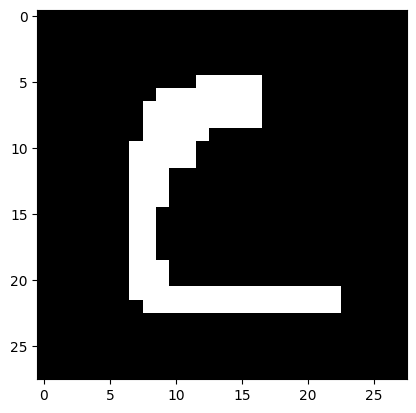

In [758]:
img = Image.open('output.png')
img = img.convert('L')

plt.imshow(img, cmap='gray')

# resize the image
img = img.resize((28, 28))

plt.imshow(np.array(img) >0.7, cmap='gray')

In [759]:
# predict the class of the image

image_decoded_1 = decode_label(letter_cluster_classifier.predict((np.array(img) >0.7).T.flatten().reshape(1,-1))[0])

In [760]:
print(f'Predicted Letter 1: {image_decoded_1}')
print(f'Predicted Letter 2: {image_decoded_2}')

Predicted Letter 1: C
Predicted Letter 2: O
